In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drd-4-classes-balanced/4_class_balanced12k_labels.npy
/kaggle/input/drd-4-classes-balanced/4_class_balanced12k.npy


In [1]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import shutil
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader,TensorDataset
from torchvision import models,transforms
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms 
import albumentations as A
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import nn
from torch.nn import DataParallel
import torchcam
from torchcam.utils import overlay_mask       
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms import ToPILImage

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
## For reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
# Loading Preprocessed data
X=np.transpose(np.load("/kaggle/input/drd-4-classes-balanced/4_class_balanced12k.npy"),(0,3,1,2))
y=np.load("/kaggle/input/drd-4-classes-balanced/4_class_balanced12k_labels.npy")

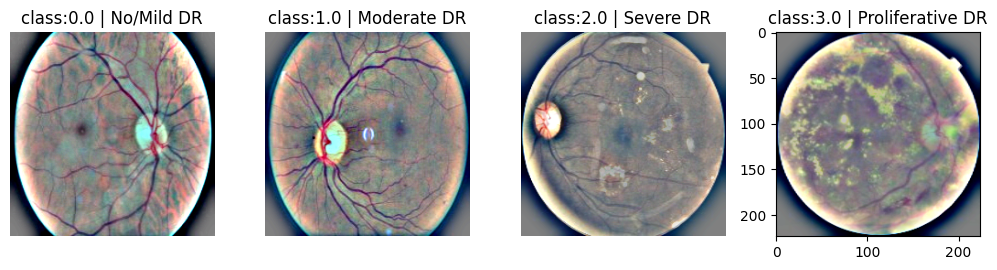

In [22]:
## Visualizing few images:
plt.figure(figsize=(10,5))
plt.subplot(1,4,1)
plt.imshow(np.transpose(X[0],(1,2,0)))
plt.title(f"class:{y[0]} | No/Mild DR")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(np.transpose(X[4500],(1,2,0)))
plt.title(f"class:{y[4500]} | Moderate DR")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(np.transpose(X[8500],(1,2,0)))
plt.title(f"class:{y[8500]} | Severe DR")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(np.transpose(X[9999],(1,2,0)))
plt.title(f"class:{y[9999]} | Proliferative DR")

plt.tight_layout()  
plt.show()

In [ ]:
torch.manual_seed(42)
X_train,X_Val_test,y_train,y_Val_test=train_test_split(X,y,shuffle=True,test_size=0.1,random_state=42)
X_val,X_test,y_Val,y_test=train_test_split(X_Val_test,y_Val_test,test_size=0.333,random_state=42)
X_train=torch.tensor(X_train)
y_train=torch.tensor(y_train,dtype=torch.long)
X_val=torch.tensor(X_val)
y_val=torch.tensor(y_Val,dtype=torch.long)
X_test=torch.tensor(X_test)
y_test=torch.tensor(y_test,dtype=torch.long)

In [ ]:
# for reproducibility while loading data
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)

In [8]:
torch.manual_seed(42)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset=TensorDataset(X_test,y_test)

# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32)
# test_dataloader=DataLoader(test_dataset,batch_size=32)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,  
    worker_init_fn=worker_init_fn, 
    pin_memory=True 
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,  
    num_workers=4,
    worker_init_fn=worker_init_fn,
    pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  
    num_workers=4,
    worker_init_fn=worker_init_fn,
    pin_memory=True
)

In [9]:
def accuracy_fn(y_true,y_preds):
    correct=torch.eq(y_true,y_preds).sum().item()
    acc=correct/len(y_true)*100
    return acc

def calculate_metrics(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    cm = confusion_matrix(true_labels, pred_labels)
    return precision, recall, f1, cm

In [ ]:
# Defining all the models used:
torch.manual_seed(42)

resnet50 = models.resnet50(weights='IMAGENET1K_V1')
resnet50.fc = torch.nn.Sequential(
    
    torch.nn.BatchNorm1d(resnet50.fc.in_features),
    torch.nn.Dropout(0.7),
    torch.nn.Linear(resnet50.fc.in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features=1024,out_features=4)
)
class Model(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.model=resnet50

    def forward(self,x):
        return self.model(x)


densenet121 = models.densenet121(weights='IMAGENET1K_V1')
densenet121.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.7),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Linear(in_features=1024,out_features=4)
)
  
class DenseModel(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.model=densenet121

    def forward(self,x):
        return self.model(x)


effnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
effnet.classifier = torch.nn.Sequential(
    torch.nn.BatchNorm1d(1280),
    torch.nn.Dropout(0.7),
    torch.nn.Linear(1280, 4))
    
class EffModel(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.model=effnet

    def forward(self,x):
        return self.model(x)


mobile=models.mobilenet_v2(weights='IMAGENET1K_V1')
mobile.classifier = torch.nn.Sequential(
    torch.nn.BatchNorm1d(1280),
    torch.nn.Dropout(0.7),
    torch.nn.Linear(1280,4))

    
class MobileModel(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.model=mobile

    def forward(self,x):
        return self.model(x)
        


In [85]:
torch.manual_seed(42)

model_A=DataParallel(Model().cuda())

## Freezing all the weights except final layer and fully connected classifier head weights
for param in model_A.model.parameters():
    param.requires_grad=False
for param in model_A.model.layer4.parameters():
    param.requires_grad=True
for param in model_A.model.fc.parameters():
    param.requires_grad+True

optimizer=torch.optim.Adam(model_A.parameters(), lr=0.0009, weight_decay=9e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-7)
loss_fn=nn.CrossEntropyLoss()

num_epochs=5
torch.manual_seed(42)
for epoch in range(num_epochs):
    # Training loop
    model_A.train()
    train_acc=0
    test_acc=0
    train_loss = 0.0
    test_loss=0
    for inputs, labels in train_dataloader:
        labels =  labels.cuda()
        inputs=inputs.cuda()
        outputs=model_A(inputs)
        optimizer.zero_grad()
        loss = loss_fn(outputs, labels)
        loss.backward()
        y_preds=outputs.argmax(axis=1)
        acc=accuracy_fn(labels,y_preds)
        train_acc+=acc
        optimizer.step()
        train_loss += loss.item()
        
    # Validation 
    model_A.eval()
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model_A(inputs)
            _, preds = torch.max(outputs, 1)
            loss=loss_fn(outputs,labels)
            test_loss+=loss
            test_preds=outputs.argmax(axis=1)
            acc=accuracy_fn(labels,test_preds)
            test_acc+=acc
    train_loss/=len(train_dataloader)
    test_loss/=len(val_dataloader)
    train_acc/=len(train_dataloader)
    test_acc/=len(val_dataloader)
    
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f}| Train Accuracy: {train_acc:.2f}% | Val Loss : {test_loss:.4f} | Val Accuracy: {test_acc:.2f}%")

#Inference:
model_A.eval()
with torch.inference_mode():
    all_test_labels = []
    all_test_preds = []
    test_acc=0
    for inputs,labels in test_dataloader:
        inputs=inputs.cuda()
        labels=labels.cuda()
        outputs=model_A(inputs)
        y_pred=outputs.argmax(axis=1)
        test_acc+=accuracy_fn(labels,y_pred)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(y_pred.cpu().numpy())
    test_acc/=len(test_dataloader)
    test_precision, test_recall, test_f1, test_cm = calculate_metrics(all_test_labels, all_test_preds)
    print(f"Test Accuracy: {test_acc :.2f}%")
    print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")
    print(f"Test Confusion Matrix:\n{test_cm}")


#saving the model weights in the working directory to download locally
torch.save(model_A.state_dict(), f'model_A_weights_32_{test_acc:.2f}.pth')
shutil.move(f'model_A_weights_32_{test_acc :.2f}.pth', f'/kaggle/working/model_A_weights_32_{test_acc :.2f}.pth')

Epoch 1/5 | Loss: 1.1645| Train Accuracy: 55.16% | Val Loss : 0.9326 | Val Accuracy: 63.00%
Epoch 2/5 | Loss: 0.7755| Train Accuracy: 67.55% | Val Loss : 0.6565 | Val Accuracy: 70.88%
Epoch 3/5 | Loss: 0.5533| Train Accuracy: 76.29% | Val Loss : 0.4969 | Val Accuracy: 76.88%
Epoch 4/5 | Loss: 0.3497| Train Accuracy: 84.82% | Val Loss : 0.5034 | Val Accuracy: 75.88%
Epoch 5/5 | Loss: 0.2054| Train Accuracy: 91.81% | Val Loss : 0.5138 | Val Accuracy: 80.75%
Test Accuracy: 80.53%
Test Precision: 0.8195 | Test Recall: 0.8025 | Test F1: 0.8035
Test Confusion Matrix:
[[ 64  19   0   1]
 [ 51  69   1   1]
 [  0   4  87   0]
 [  1   0   1 101]]


'/kaggle/working/model_A_weights_32_80.53.pth'

In [20]:
model_B=DataParallel(DenseModel().cuda())

## Freezing all the weights except for few final densenet layers and classifier head weights
for param in model_B.model.parameters():
    param.requires_grad=False
for param in model_B.model.features[-6:].parameters():
    param.requires_grad = True
for param in model_B.model.classifier.parameters():
    param.requires_grad=True

optimizer=torch.optim.Adam(model_B.parameters(), lr=0.001, weight_decay=7e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-7)
loss_fn=nn.CrossEntropyLoss()


num_epochs=7
torch.manual_seed(42)
for epoch in range(num_epochs):
    model_B.train()
    train_acc=0
    test_acc=0
    train_loss = 0.0
    test_loss=0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model_B(inputs)
        optimizer.zero_grad()
        loss = loss_fn(outputs, labels)
        loss.backward()
        y_preds=outputs.argmax(axis=1)
        acc=accuracy_fn(labels,y_preds)
        train_acc+=acc
        optimizer.step()
        train_loss += loss.item()
        
    # Validation phase
    model_B.eval()
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model_B(inputs)
            _, preds = torch.max(outputs, 1)
            loss=loss_fn(outputs,labels)
            test_loss+=loss
            test_preds=outputs.argmax(axis=1)
            acc=accuracy_fn(labels,test_preds)
            test_acc+=acc
    scheduler.step()
    train_loss/=len(train_dataloader)
    test_loss/=len(val_dataloader)
    train_acc/=len(train_dataloader)
    test_acc/=len(val_dataloader)
    
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f}| Train Accuracy: {train_acc:.2f}% | Val Loss : {test_loss:.4f} | Val Accuracy: {test_acc:.2f}%")
#Inference:
model_B.eval()
with torch.inference_mode():
    all_test_labels = []
    all_test_preds = []
    test_acc=0
    for inputs,labels in test_dataloader:
        inputs=inputs.cuda()
        labels=labels.cuda()
        outputs=model_B(inputs)
        y_pred=outputs.argmax(axis=1)
        test_acc+=accuracy_fn(labels,y_pred)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(y_pred.cpu().numpy())
    test_acc/=len(test_dataloader)
    test_precision, test_recall, test_f1, test_cm = calculate_metrics(all_test_labels, all_test_preds)
    print(f"Test Accuracy: {test_acc :.2f}%")
    print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")
    print(f"Test Confusion Matrix:\n{test_cm}")


#saving the model weights in the working directory to download locally
torch.save(model_B.state_dict(), f'model_B_weights_32_{test_acc:.2f}.pth')
shutil.move(f'model_B_weights_32_{test_acc :.2f}.pth', f'/kaggle/working/model_B_weights_32_{test_acc :.2f}.pth')


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 156MB/s] 


Epoch 1/7 | Loss: 0.9383| Train Accuracy: 58.95% | Val Loss : 0.8784 | Val Accuracy: 63.38%
Epoch 2/7 | Loss: 0.7668| Train Accuracy: 66.42% | Val Loss : 0.8263 | Val Accuracy: 62.12%
Epoch 3/7 | Loss: 0.6489| Train Accuracy: 72.17% | Val Loss : 0.6432 | Val Accuracy: 70.00%
Epoch 4/7 | Loss: 0.5145| Train Accuracy: 77.51% | Val Loss : 0.5037 | Val Accuracy: 79.50%
Epoch 5/7 | Loss: 0.3892| Train Accuracy: 83.79% | Val Loss : 0.4724 | Val Accuracy: 79.50%
Epoch 6/7 | Loss: 0.2634| Train Accuracy: 90.11% | Val Loss : 0.4641 | Val Accuracy: 83.12%
Epoch 7/7 | Loss: 0.1574| Train Accuracy: 95.07% | Val Loss : 0.4796 | Val Accuracy: 83.62%
Test Accuracy: 82.21%
Test Precision: 0.8206 | Test Recall: 0.8225 | Test F1: 0.8211
Test Confusion Matrix:
[[ 52  32   0   0]
 [ 25  89   7   1]
 [  0   4  87   0]
 [  0   1   1 101]]


'/kaggle/working/model_B_weights_32_82.21.pth'

In [92]:
model_C=DataParallel(EffModel().cuda())

## Freezing all the weights except for few final densenet layers and classifier head weights
for param in model_C.model.parameters():
    param.requires_grad=False
for param in  model_C.model.features[-3:].parameters():
    param.requires_grad = True
for param in  model_C.model.classifier.parameters():
    param.requires_grad=True

num_epochs=7

#optimizer=torch.optim.lr_scheduler.ReduceLROnPlateau(model_C.parameters(),lr=0.0005,mode='min',factor=0.5,patience=3)
optimizer=torch.optim.Adam(model_C.parameters(), lr=0.001, weight_decay=7e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-7)
loss_fn=nn.CrossEntropyLoss()
torch.manual_seed(42)

#Traaining loop
for epoch in range(num_epochs):
    model_C.train()
    train_acc=0
    test_acc=0
    train_loss = 0.0
    test_loss=0
    for inputs, labels in train_dataloader:
        labels=labels.cuda()
        inputs=inputs.cuda()
        outputs=model_C(inputs)
        optimizer.zero_grad()
        loss = loss_fn(outputs, labels)
        loss.backward()
        y_preds=outputs.argmax(axis=1)
        acc=accuracy_fn(labels,y_preds)
        train_acc+=acc
        optimizer.step()
        train_loss += loss.item()
        
    # Validation 
    model_C.eval()
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model_C(inputs)
            _, preds = torch.max(outputs, 1)
            loss=loss_fn(outputs,labels)
            test_loss+=loss
            test_preds=outputs.argmax(axis=1)
            acc=accuracy_fn(labels,test_preds)
            test_acc+=acc
    scheduler.step()
    train_loss/=len(train_dataloader)
    test_loss/=len(val_dataloader)
    train_acc/=len(train_dataloader)
    test_acc/=len(val_dataloader)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}% | Val Loss : {test_loss:.4f} | Val Accuracy: {test_acc:.2f}%")

#Inference:
model_C.eval()
with torch.inference_mode():
    all_test_labels = []
    all_test_preds = []
    test_acc=0
    for inputs,labels in test_dataloader:
        inputs=inputs.cuda()
        labels=labels.cuda()
        outputs=model_C(inputs)
        y_pred=outputs.argmax(axis=1)
        test_acc+=accuracy_fn(labels,y_pred)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(y_pred.cpu().numpy())

    test_acc/=len(test_dataloader)
    test_precision, test_recall, test_f1, test_cm = calculate_metrics(all_test_labels, all_test_preds)
    print(f"Test Accuracy: {test_acc :.2f}%")
    print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")
    print(f"Test Confusion Matrix:\n{test_cm}")

#saving the model weights in the working directory to download locally
torch.save(model_C.state_dict(), f'model_C_weights_32_{test_acc:.2f}.pth')
shutil.move(f'model_C_weights_32_{test_acc :.2f}.pth', f'/kaggle/working/model_C_weights_32_{test_acc :.2f}.pth')    

Epoch 1/10 | Loss: 1.1159 | Train Accuracy: 53.51% | Val Loss : 0.9265 | Val Accuracy: 62.75%
Epoch 2/10 | Loss: 0.9484 | Train Accuracy: 61.18% | Val Loss : 0.9907 | Val Accuracy: 60.00%
Epoch 3/10 | Loss: 0.9105 | Train Accuracy: 62.93% | Val Loss : 0.7543 | Val Accuracy: 66.50%
Epoch 4/10 | Loss: 0.7990 | Train Accuracy: 67.60% | Val Loss : 0.6393 | Val Accuracy: 73.25%
Epoch 5/10 | Loss: 0.7131 | Train Accuracy: 70.59% | Val Loss : 0.6125 | Val Accuracy: 72.88%
Epoch 6/10 | Loss: 0.5915 | Train Accuracy: 75.24% | Val Loss : 0.5454 | Val Accuracy: 73.00%
Epoch 7/10 | Loss: 0.5122 | Train Accuracy: 78.54% | Val Loss : 0.5488 | Val Accuracy: 77.88%
Epoch 8/10 | Loss: 0.4375 | Train Accuracy: 81.42% | Val Loss : 0.5022 | Val Accuracy: 78.00%
Epoch 9/10 | Loss: 0.3678 | Train Accuracy: 84.99% | Val Loss : 0.4355 | Val Accuracy: 82.38%
Epoch 10/10 | Loss: 0.3283 | Train Accuracy: 86.38% | Val Loss : 0.4378 | Val Accuracy: 80.38%
Test Accuracy: 77.16%
Test Precision: 0.7739 | Test Recall:

'/kaggle/working/model_C_weights_32_77.16.pth'

In [121]:
model_D=DataParallel(MobileModel().cuda())

for param in model_D.model.parameters():
    param.requires_grad=False
for param in model_D.model.features[-8:].parameters():
    param.requires_grad = True
for param in model_D.model.classifier.parameters():
    param.requires_grad=True

optimizer=torch.optim.Adam(model_D.parameters(), lr=0.001, weight_decay=9e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-7)
loss_fn=nn.CrossEntropyLoss()

num_epochs=5
torch.manual_seed(42)
#Trainin Loop
for epoch in range(num_epochs):
    model_D.train()
    train_acc=0
    test_acc=0
    train_loss = 0.0
    test_loss=0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model_D(inputs)
        optimizer.zero_grad()
        loss = loss_fn(outputs, labels)
        loss.backward()
        y_preds=outputs.argmax(axis=1)
        acc=accuracy_fn(labels,y_preds)
        train_acc+=acc
        optimizer.step()
        train_loss += loss.item()
        
    # Validation 
    model_D.eval()
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model_D(inputs)
            _, preds = torch.max(outputs, 1)
            loss=loss_fn(outputs,labels)
            test_loss+=loss
            test_preds=outputs.argmax(axis=1)
            acc=accuracy_fn(labels,test_preds)
            test_acc+=acc
    scheduler.step()
    train_loss/=len(train_dataloader)
    test_loss/=len(val_dataloader)
    train_acc/=len(train_dataloader)
    test_acc/=len(val_dataloader)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f}| Train Accuracy: {train_acc:.2f}% | Val Loss : {test_loss:.4f} | Val Accuracy: {test_acc:.2f}%")

#Inference:
model_D.eval()
with torch.inference_mode():
    all_test_labels = []
    all_test_preds = []
    test_acc=0
    for inputs,labels in test_dataloader:
        inputs=inputs.cuda()
        labels=labels.cuda()
        outputs=model_D(inputs)
        y_pred=outputs.argmax(axis=1)
        test_acc+=accuracy_fn(labels,y_pred)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(y_pred.cpu().numpy())

    test_acc/=len(test_dataloader)
    test_precision, test_recall, test_f1, test_cm = calculate_metrics(all_test_labels, all_test_preds)
    print(f"Test Accuracy: {test_acc :.2f}%")
    print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")
    print(f"Test Confusion Matrix:\n{test_cm}")


#saving the model weights in the working directory to download locally
torch.save(model_D.state_dict(), f'model_D_weights_32_{test_acc:.2f}.pth')
shutil.move(f'model_D_weights_32_{test_acc :.2f}.pth', f'/kaggle/working/model_D_weights_32_{test_acc :.2f}.pth')

Epoch 1/5 | Loss: 1.0512| Train Accuracy: 55.83% | Val Loss : 0.8119 | Val Accuracy: 66.62%
Epoch 2/5 | Loss: 0.8181| Train Accuracy: 65.16% | Val Loss : 0.7071 | Val Accuracy: 66.88%
Epoch 3/5 | Loss: 0.6687| Train Accuracy: 71.25% | Val Loss : 0.5776 | Val Accuracy: 73.12%
Epoch 4/5 | Loss: 0.4673| Train Accuracy: 80.22% | Val Loss : 0.5295 | Val Accuracy: 75.88%
Epoch 5/5 | Loss: 0.3012| Train Accuracy: 87.85% | Val Loss : 0.4568 | Val Accuracy: 80.25%
Test Accuracy: 78.85%
Test Precision: 0.7923 | Test Recall: 0.7900 | Test F1: 0.7827
Test Confusion Matrix:
[[ 64  19   0   1]
 [ 40  64  13   5]
 [  1   2  88   0]
 [  0   1   2 100]]


'/kaggle/working/model_D_weights_32_78.85.pth'

In [13]:
# Function to plot Heat maps to visualize which region of the image the model focuses more on: (using torchcam)
def plot_heat_maps(test_model,target_layer):
    
    
    #Selecting 2 random images from test set 
    random_indices = random.sample(range(len(X_test)), 2)
    
    
    fig, axs = plt.subplots(len(random_indices), 2, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.4)
    
    cam_extractor = SmoothGradCAMpp(test_model,target_layer=target_layer)
    
    test_model.eval()
    for i, idx in enumerate(random_indices):
        img = X_test[idx].reshape(3, 224, 224).cuda()
        label = y_test[idx]
    
        img.requires_grad = True
        out = test_model(img.unsqueeze(0))
        prediction = out.argmax().item()
    
        # Generating Grad-CAM heatmap
        cams = cam_extractor(out.argmax().item(), out)
        heatmap = overlay_mask(to_pil_image(img.cpu()), to_pil_image(cams[0].squeeze(0), mode='F'), alpha=0.5)
    
        # Displaying the original image for comparision
        axs[i, 0].imshow(to_pil_image(img.cpu()))
        axs[i, 0].set_title(f"Original Image\nPrediction: {prediction}, Label: {label}")
        axs[i, 0].axis('off')
    
        # Displaying the Grad-CAM heatmap
        axs[i, 1].imshow(heatmap)
        axs[i, 1].set_title("Grad-CAM Heatmap")
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Removing hooks after generating Grad-CAM heatmaps
    cam_extractor.remove_hooks()

In [ ]:
# since i am saving weights from models trained Parallely on 2 GPUs using DataParallel, i will get a 'module' prefix in the state dict which needs to be removed while loading best models.

def load_model_weights(model, weight_path):
    state_dict = torch.load(weight_path, map_location='cuda:0',weights_only=True)  
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)

Resnet50



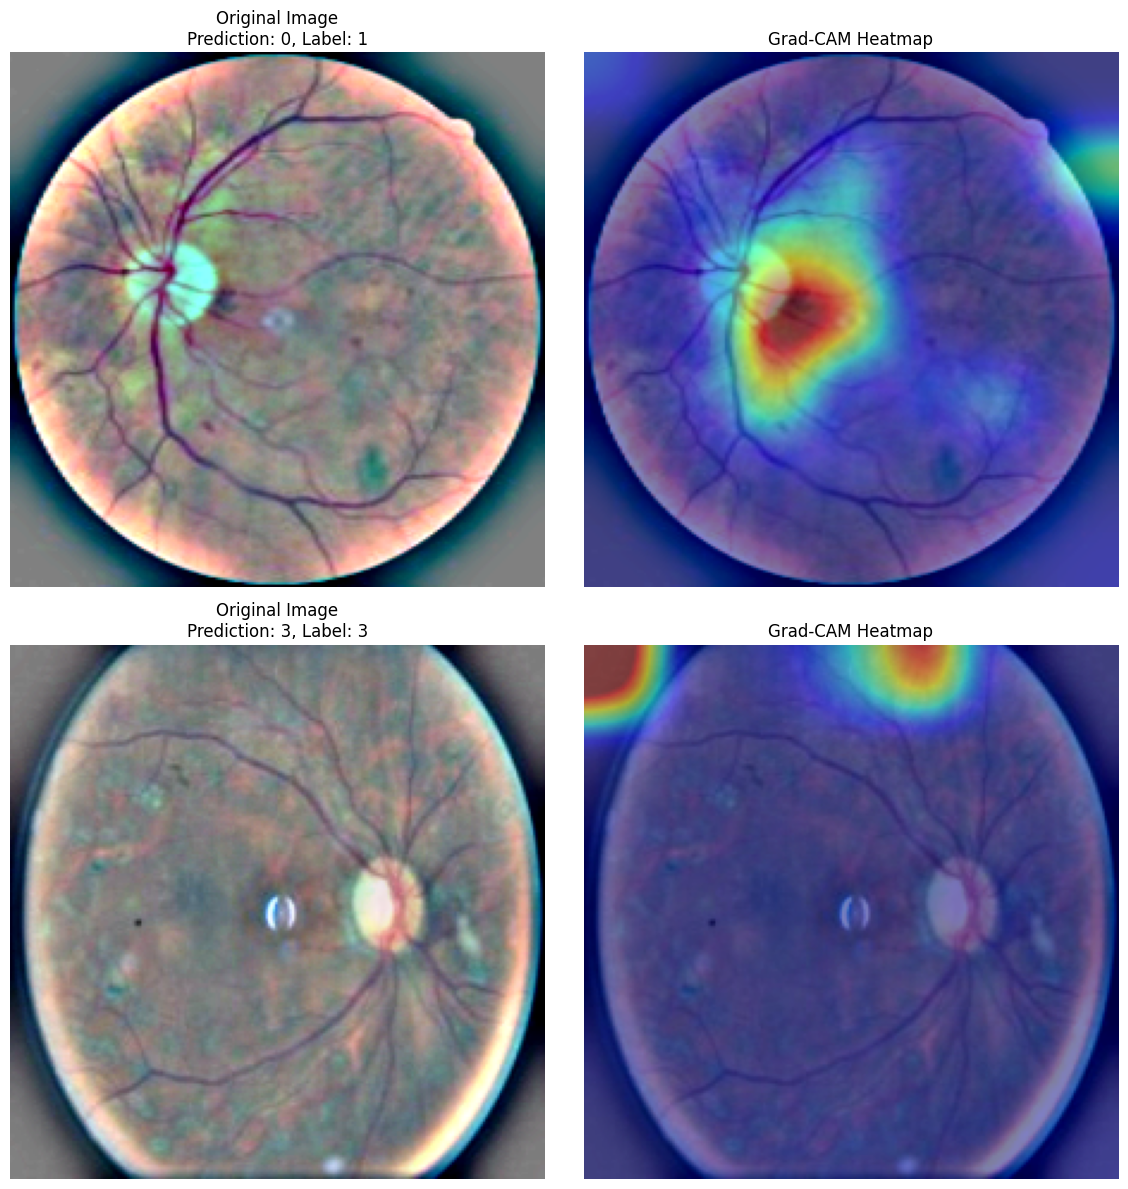

Densenet121



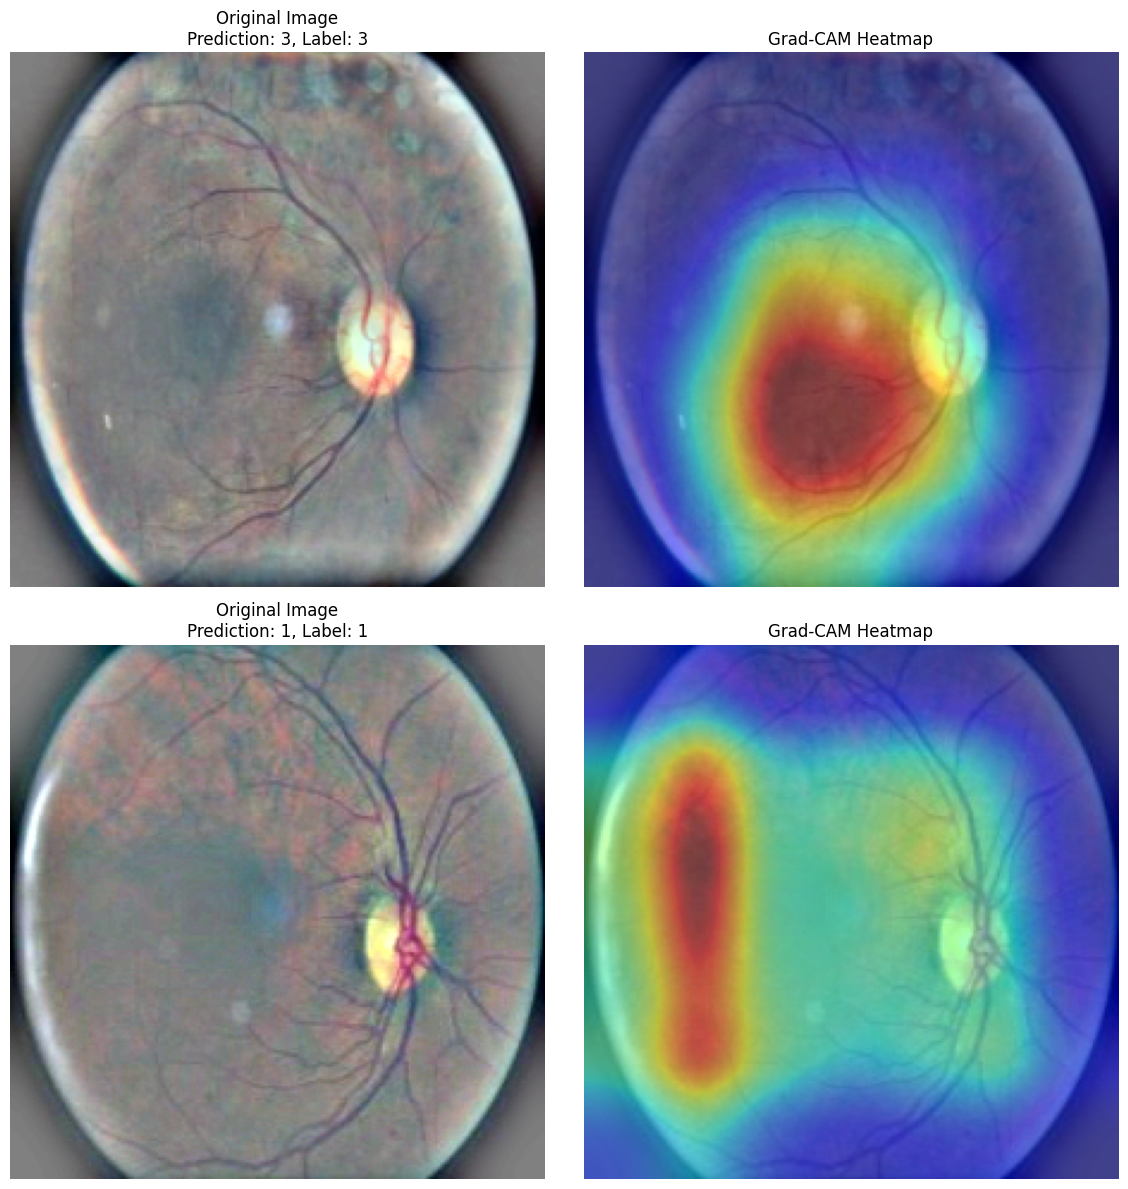

Efficientnet



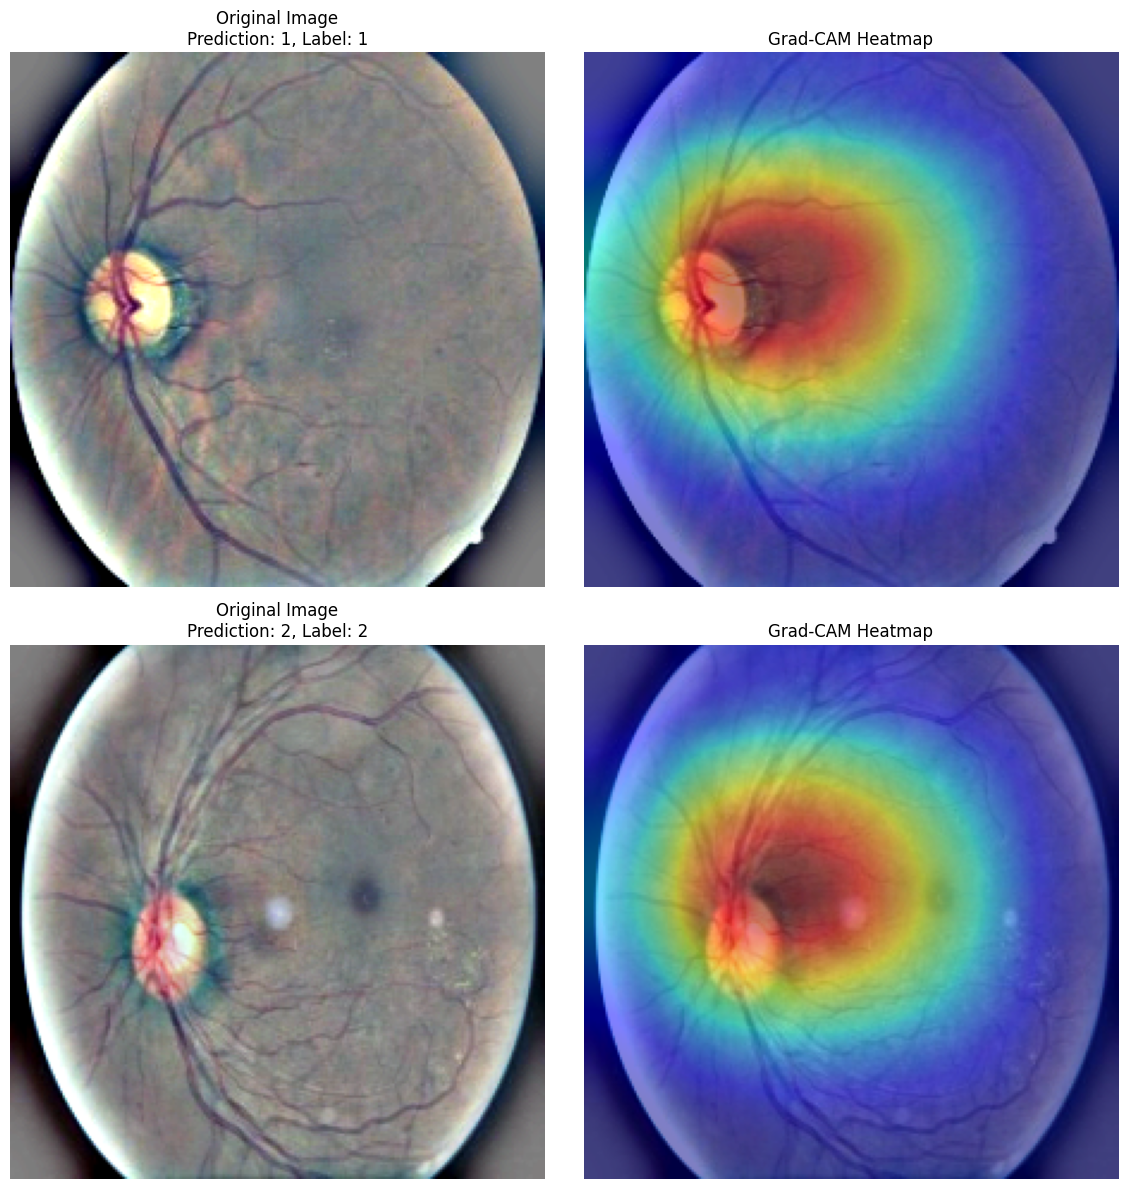

Mobilenet



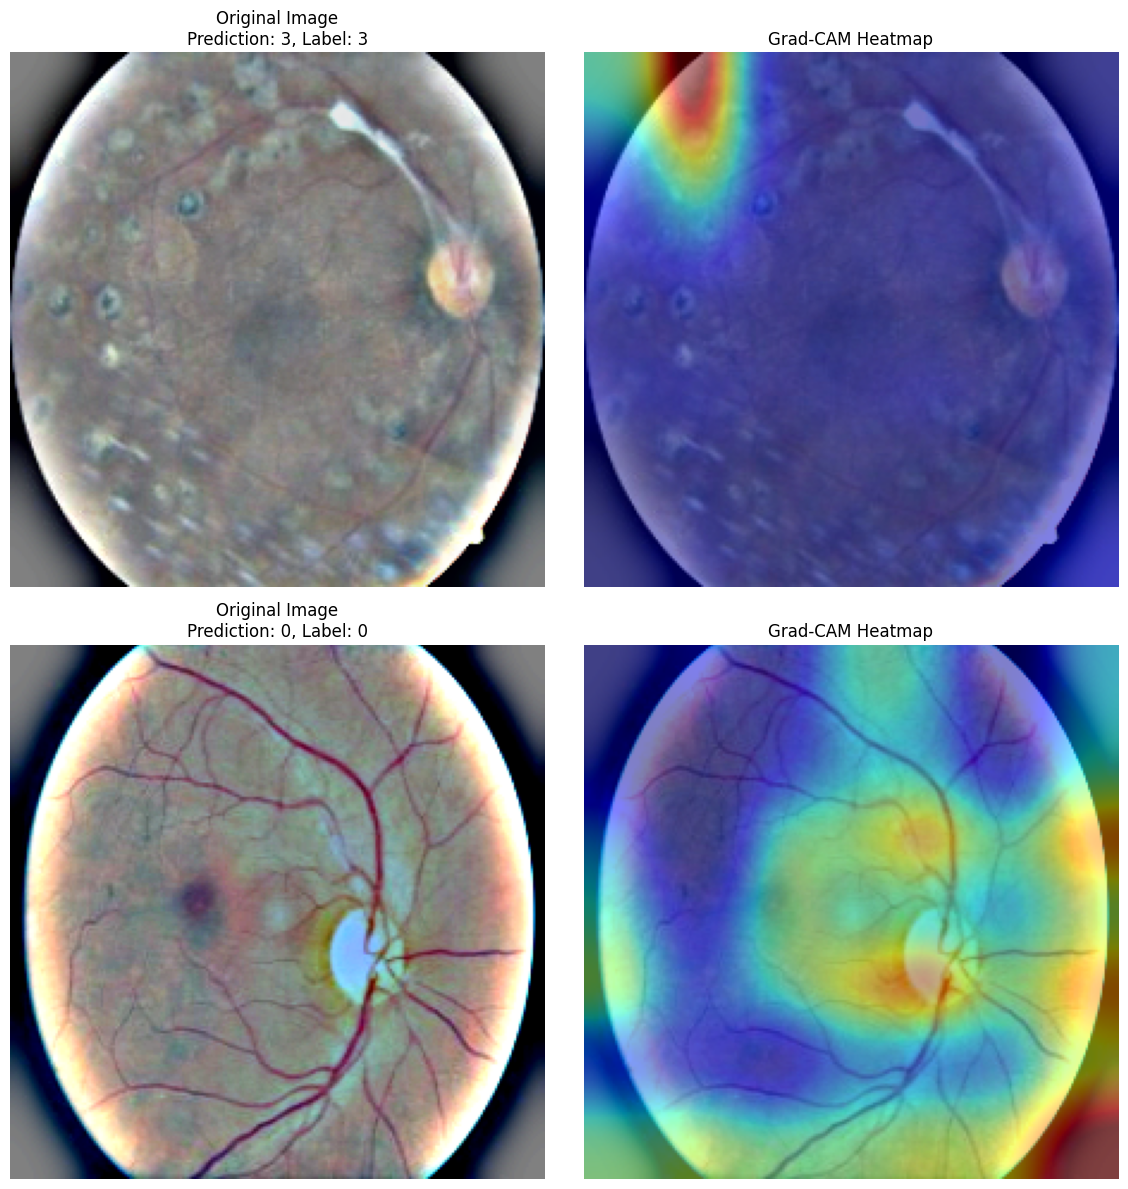

In [21]:
## Visualizing Heat Maps from each model

print("Resnet50\n")
test_model=Model().cuda()
load_model_weights(test_model,'/kaggle/input/finetunedweights/model_A_weights_32_80.53.pth')
for param in test_model.parameters():
    param.requires_grad=True
target_layer=test_model.model.layer4[-1]
plot_heat_maps(test_model,target_layer)

print("Densenet121\n")

test_model=DenseModel().cuda()
load_model_weights(test_model,'/kaggle/input/finetunedweights/model_B_weights_32_82.21.pth')
for param in test_model.parameters():
    param.requires_grad=True
target_layer=test_model.model.features.denseblock4.denselayer16.conv2
plot_heat_maps(test_model,target_layer)
  
print("Efficientnet\n")

test_model=EffModel().cuda()
load_model_weights(test_model,'/kaggle/input/finetunedweights/model_C_weights_32_79.81.pth')
for param in test_model.parameters():
    param.requires_grad=True
plot_heat_maps(test_model,test_model.model.features[-1])

print("Mobilenet\n")

test_model=MobileModel().cuda()
load_model_weights(test_model,'/kaggle/input/finetunedweights/model_D_weights_32_79.09.pth')
for param in test_model.parameters():
    param.requires_grad=True
plot_heat_maps(test_model,test_model.model.features[-1])

In [22]:
#Ensemble model structure: 

model_A=Model().cuda()
model_B=DenseModel().cuda()
model_C=EffModel().cuda()
model_D=MobileModel().cuda()

# Loading the best weights of each model after fine tuning:
load_model_weights(model_A, '/kaggle/input/finetunedweights/model_A_weights_32_80.53.pth')
load_model_weights(model_B, '/kaggle/input/finetunedweights/model_B_weights_32_82.21.pth')
load_model_weights(model_C, '/kaggle/input/finetunedweights/model_C_weights_32_79.81.pth')
load_model_weights(model_D, '/kaggle/input/finetunedweights/model_D_weights_32_79.09.pth')

#Freezing the weights of theese models and training only the classification head of the Ensemble model
for param in model_A.parameters():
    param.requires_grad=False
for param in model_B.parameters():
    param.requires_grad=False
for param in model_C.parameters():
    param.requires_grad=False
for param in model_D.parameters():
    param.requires_grad=False


class EnsembleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model_A=model_A
        self.model_B=model_B
        self.model_C=model_C
        self.model_D=model_D
        self.classifier=nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(16,8),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(8,4)
            )
    def forward(self,x):
        x1 = self.model_A(x)
        x2 = self.model_B(x)
        x3 = self.model_C(x)
        x4 = self.model_D(x)

        out=torch.cat([x1,x2,x3,x4],dim=1)
        return self.classifier(out)


In [27]:
num_epochs=7     
model=DataParallel(EnsembleModel().cuda())
optimizer=torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay=7e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
loss_fn=nn.CrossEntropyLoss()
torch.manual_seed(42)
for epoch in range(num_epochs):
    model.train()
    train_acc=0
    test_acc=0
    train_loss = 0.0
    test_loss=0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = loss_fn(outputs, labels)
        loss.backward()
        y_preds=outputs.argmax(axis=1)
        acc=accuracy_fn(labels,y_preds)
        train_acc+=acc
        optimizer.step()
        train_loss += loss.item()
        
    # Validation 
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss=loss_fn(outputs,labels)
            test_loss+=loss
            test_preds=outputs.argmax(axis=1)
            acc=accuracy_fn(labels,test_preds)
            test_acc+=acc
    scheduler.step()
    train_loss/=len(train_dataloader)
    test_loss/=len(val_dataloader)
    train_acc/=len(train_dataloader)
    test_acc/=len(val_dataloader)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f}| Train Accuracy: {train_acc:.2f}% | Val Loss : {test_loss:.4f} | Val Accuracy: {test_acc:.2f}%")

#Inference:
model.eval()
with torch.inference_mode():
    all_test_labels = []
    all_test_preds = []
    test_acc=0
    for inputs,labels in test_dataloader:
        inputs=inputs.cuda()
        labels=labels.cuda()
        outputs=model(inputs)
        y_pred=outputs.argmax(axis=1)
        test_acc+=accuracy_fn(labels,y_pred)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(y_pred.cpu().numpy())
    test_acc/= len(test_dataloader)
    test_precision, test_recall, test_f1, test_cm = calculate_metrics(all_test_labels, all_test_preds)
    print(f"Test Accuracy: {test_acc :.2f}%")
    print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")
    print(f"Test Confusion Matrix:\n{test_cm}")


#saving the model weights in the working directory to download locally
torch.save(model.state_dict(), f'ensemble_model_weights_32_{test_acc:.2f}.pth')
shutil.move(f'ensemble_model_weights_32_{test_acc :.2f}.pth', f'/kaggle/working/ensemble_model_weights_32_{test_acc :.2f}.pth')      

Epoch 1/7 | Loss: 1.0373| Train Accuracy: 57.52% | Val Loss : 0.5308 | Val Accuracy: 82.12%
Epoch 2/7 | Loss: 0.6366| Train Accuracy: 74.37% | Val Loss : 0.3971 | Val Accuracy: 84.62%
Epoch 3/7 | Loss: 0.5567| Train Accuracy: 77.60% | Val Loss : 0.3689 | Val Accuracy: 84.62%
Epoch 4/7 | Loss: 0.5190| Train Accuracy: 79.96% | Val Loss : 0.3549 | Val Accuracy: 84.38%
Epoch 5/7 | Loss: 0.4997| Train Accuracy: 81.15% | Val Loss : 0.3570 | Val Accuracy: 85.75%
Epoch 6/7 | Loss: 0.4889| Train Accuracy: 81.09% | Val Loss : 0.3637 | Val Accuracy: 85.75%
Epoch 7/7 | Loss: 0.4926| Train Accuracy: 81.41% | Val Loss : 0.3493 | Val Accuracy: 84.62%
Test Accuracy: 83.65%
Test Precision: 0.8521 | Test Recall: 0.8400 | Test F1: 0.8390
Test Confusion Matrix:
[[ 70  14   0   0]
 [ 41  76   4   1]
 [  0   2  89   0]
 [  0   1   1 101]]


'/kaggle/working/ensemble_model_weights_32_83.65.pth'

In [23]:
test_model=EnsembleModel().cuda()
load_model_weights(test_model,'/kaggle/input/finetunedweights/ensemble_model_weights_32_83.65.pth')
test_model.eval()
with torch.inference_mode():
    all_test_labels = []
    all_test_preds = []
    test_acc=0
    for inputs,labels in test_dataloader:
        inputs=inputs.cuda()
        labels=labels.cuda()
        outputs=test_model(inputs)
        y_pred=outputs.argmax(axis=1)
        test_acc+=accuracy_fn(labels,y_pred)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(y_pred.cpu().numpy())
    test_acc/= len(test_dataloader)
    test_precision, test_recall, test_f1, test_cm = calculate_metrics(all_test_labels, all_test_preds)
    print(f"Test Accuracy: {test_acc :.2f}%")
    print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1: {test_f1:.4f}")
    print(f"Test Confusion Matrix:\n{test_cm}")



Test Accuracy: 83.65%
Test Precision: 0.8521 | Test Recall: 0.8400 | Test F1: 0.8390
Test Confusion Matrix:
[[ 70  14   0   0]
 [ 41  76   4   1]
 [  0   2  89   0]
 [  0   1   1 101]]
